# Under- and overfitting, model selection

## Preliminaries

In the first set of exercises you had to implement the training and evaluation of the linear regression and $k$-NN methods from scratch in order to practice your `numpy` skills. From this set of exercises onward, you can use the implementations provided in `scikit-learn` or other higher-level libraries. We start this set of exercises by demonstrating some of the features of `scikit-learn`.

For example, implementation of linear regression model fitting with an analytical solution for the parameters is provided by the class `sklearn.linar_model.LinearRegression`. You can train a linear regression model in the following way:

In [1]:
import numpy as np
from sklearn import datasets, linear_model

# load the diabetes dataset
diabetes = datasets.load_diabetes()

# use only one feature
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

# split the data into training/testing sets
X_train = X[:-20]
X_test = X[-20:]

# split the targets into training/testing sets
y_train = y[:-20]
y_test = y[-20:]

# create linear regression object
model = linear_model.LinearRegression()

# train the model using the training dataset
model.fit(X_train, y_train)

LinearRegression()

Let's visualize the training dataset and the learned regression model.

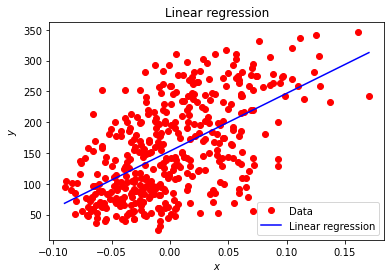

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(X_train, y_train, 'r.', markersize=12)
X_edge = np.array([np.min(X_train, 0), np.max(X_train, 0)])
plt.plot(X_edge, model.predict(X_edge), 'b-')
plt.legend(('Data', 'Linear regression'), loc='lower right')
plt.title('Linear regression')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Once trained, the model can be used to make predictions on the test data:

In [3]:
# Make predictions using the testing dataset
prediction = model.predict(X_test)

The next step (not shown here) is to evaluate the performance of the trained model.

Note that the `scikit-learn` interface works by first initializing an object from the class that implements the machine learning model (linear regression in this case) and then fitting the initialized model using the data in the training set. Finally, the trained (fitted) model can be used to make predictions on unseen data. In fact, all models implemented in this library follow the same *initialize-fit-predict* programming interface. For example, a $k$-NN classifier can be trained in the following way:

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors

breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

# make use of the train_test_split() utility function instead
# of manually dividing the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

# initialize a 3-NN classifier
model = neighbors.KNeighborsClassifier(n_neighbors=3)

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)

Note that the features in the breast cancer dataset have different scales (some have on average very small absolute values, and some very large), which means that the distance metric used by $k$-NN will me dominated by the features with large values. You can use any of the number of feature transformation methods implemented in `scikit-learn` to scale the features. For example, you can use the `sklearn.preprocessing.StandardScaler` method to transform all features to a have a zero mean and unit variance:

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

The scaler has its own parameters which are the means and standard deviations of the features estimated from the training set. If you train a model with the scaled features, you will have to remember to also apply the scaling transformation every time you make a prediction on new unseen and unscaled data. This is somewhat prone to error. One option for making the code more robust is to create a processing pipeline that includes the scaling and $k$-NN models in a sequence:

In [6]:
from sklearn.pipeline import Pipeline

knn = neighbors.KNeighborsClassifier(n_neighbors=3)

model = Pipeline([
                 ("scaler", scaler),
                 ("knn", knn)
                ])

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)


If you are curious, more information about the design of the `scikit-learn` application programming interface (API) can be found [in this paper](https://arxiv.org/pdf/1309.0238.pdf). 

## Exercises

### Bias-variance decomposition

Show that the mean squared error of the estimate of a parameter can be decomposed into an expression that includes both the bias and variance (Eq. 5.53-5.54 in "Deep learning" by Goodfellow et al.). 

### Polynomial regression

For this exercise we will be using generated data to better show the effects of the different polynomial orders.
The data is created using the make_polynomial_regression function.

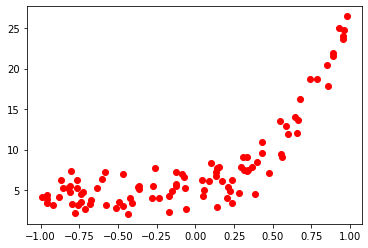

In [7]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

def generate_dataset(n=100, degree=1, noise=1, factors=None):
    # Generates a dataset by adding random noise to a randomly
    # generated polynomial function.
    
    x = np.random.uniform(low=-1, high=1, size=n)
    
    factors = np.random.uniform(0, 10, degree+1)
    
    y = np.zeros(x.shape)
    
    for idx in range(degree+1):
        y += factors[idx] * (x ** idx)

    # add noise
    y += np.random.normal(-noise, noise, n)
    
    return x, y

# load generated data
np.random.seed(0)

X, y = generate_dataset(n=100, degree=4, noise=1.5)

plt.plot(X, y, 'r.', markersize=12)

Implement polynomial regression using the `sklearn.preprocessing.PolynomialFeatures` transformation. Using the `sklearn.grid_search.GridSearchCV` class, perform a grid search of the polynomial order hyperparameter space with cross-validation and report the performance on an independent test set.

Plot a learning curve that show the validation accuracy as a function of the polynomial order. 

<p><font color='#770a0a'>Which models have a high bias, and which models have high variance? Motivate your answer.</font><p>
    
Repeat this experiment, this time using the diabetes dataset instead of the generated data.

Pipeline(steps=[('scaler', StandardScaler()),
                ('transf', PolynomialFeatures(degree=6)),
                ('linear_regression', LinearRegression())])


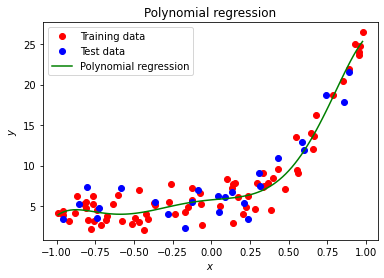

Mean squared error for the generated dataset: 3.18
Mean squared error for the diabetes dataset: 3.43e+03


Text(0.0, -0.25, 'Figure 3: Learning curve diabetes data')

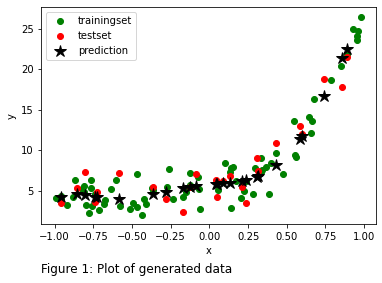

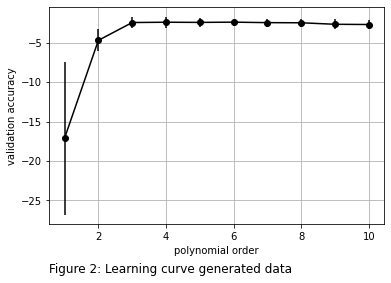

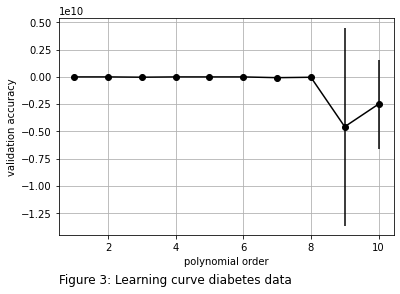

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Make the generated data 2D arrays, so we can perform operations on the matrices
X_2d = X[:, np.newaxis]
y_2d = y[:, np.newaxis]

# Split the data in the default 75 % training and 25 % test data
X_train, X_test, y_train, y_test = train_test_split(X_2d, y_2d)

# Create a processing pipeline that includes the polynomial degree and the linear regression
model = Pipeline([
                 ("scaler", StandardScaler()),
                 ("transf", PolynomialFeatures()),                         
                 ("linear_regression", linear_model.LinearRegression())
                ])

# Test for polynomials of degree 1 to 10
degrees = np.arange(1, 11)

# Put these degrees into a dictionary to use as parameters in the grid search
param_grid = {'transf__degree': degrees}

# Perform a grid search of the polynomial order with the default 5-fold cross validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)
prediction = grid_search.predict(X_test)

# See which polynomial degree fits the data best
print(grid_search.best_estimator_)

# Visualize the datasets with the learned polynomial regression model
fig = plt.figure()
plt.plot(X_train, y_train, 'r.', markersize=12)
plt.plot(X_test, y_test, 'b.', markersize=12)
X_prediction = np.linspace(np.min(X_train, 0), np.max(X_train, 0), 100)
y_prediction = grid_search.best_estimator_.predict(X_prediction)
plt.plot(X_prediction, y_prediction, 'g-')
plt.legend(('Training data', 'Test data', 'Polynomial regression'), loc='upper left')
plt.title('Polynomial regression')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

# Evaluate the performance of the model
mse = mean_squared_error(y_test, prediction)
print('Mean squared error for the generated dataset: {:.2f}'.format(mse))

# Plot prediction
plt.figure()
plt.plot(X_train, y_train, 'g.', markersize=12, label='trainingset')
plt.plot(X_test, y_test, 'r.', markersize=12, label='testset')
plt.plot(X_test, prediction, 'k*', markersize=12, label='prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Figure 1: Plot of generated data', y=-0.25, loc='left')


# _______________Plot learning curve_________________________________
# Read test scores
validation_accuracy = grid_search.cv_results_['mean_test_score']
va_std = grid_search.cv_results_['std_test_score']

# Generate plot
plt.figure()
plt.errorbar(degrees, validation_accuracy, va_std, fmt='k-o')
plt.xlabel('polynomial order')
plt.ylabel('validation accuracy')
plt.grid('on')
plt.title('Figure 2: Learning curve generated data', y=-0.25, loc='left')

# _____________Diabetes dataset___________________________________________
# Read data
X_diab = diabetes.data
y_diab = diabetes.target

# Split data
X_diab_train, X_diab_test, y_diab_train, y_diab_test = train_test_split(X_diab, y_diab)

# Perform grid search
grid_search2 = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the model
grid_search2.fit(X_diab_train, y_diab_train)
prediction_diab = grid_search2.predict(X_diab_test)

# Evaluate performance
mse_diab = mean_squared_error(y_diab_test, prediction_diab)
print('Mean squared error for the diabetes dataset: {:.2e}'.format(mse_diab))

# _______________Plot learning curve_________________________________
# Read test scores
validation_accuracy_diab = grid_search2.cv_results_['mean_test_score']
va_std_diab = grid_search2.cv_results_['std_test_score']

# Generate plot
plt.figure()
plt.errorbar(degrees, validation_accuracy_diab, va_std_diab, fmt='k-o')
plt.xlabel('polynomial order')
plt.ylabel('validation accuracy')
plt.grid('on')
plt.title('Figure 3: Learning curve diabetes data', y=-0.25, loc='left')


***Question:*** Which models have a high bias, and which models have high variance? Motivate your answer.

***Answer:*** Models with a low complexity give a high bias, while models with a high complexity give a high variance. Bias measures the deviation of the estimator's expected value with the estimator's true value. High bias causes underfitting of the data, so the model might not have learned all relations between the data. Therefore, the bias decreases as the capacity of the model increases. Variance measures the deviation from the estimator's expected value depending on the particular
data sampling. High variance causes overfitting of the data, so the model is very sensitive to small changes in the training data. Thus, the variance increases as the capacity increases.

### ROC curve analysis
A common method to evaluate binary classifiers is the receiver operating characteristic (ROC) curve. Similar to the week one practicals, implement a $k$-NN classifier on the breast cancer dataset, however, his time use the $k$-NN pipeline from the preliminary. Train the model for different values of $k$ and evaluate their respective performance with an ROC curve, use the `sklearn.metrics.roc_curve` function.

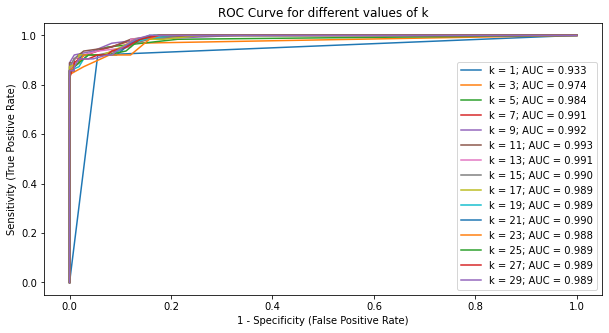

In [9]:
from sklearn import datasets, neighbors
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

# load dataset
breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data # data matrix
y = breast_cancer.target # classification target, 0 or 1

# Split X and y intro training and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

test_acc = [] # testing accuracy
train_acc = [] # training accuracy

plt.figure(figsize=(10, 5))
ks = range (1, 30, 2)
for k in ks:
    # Setting up Machine Learning Pipeline: Sequentially apply a list of transforms and a final estimator. 
    model = Pipeline([("scaler", StandardScaler()), ("classifier", neighbors.KNeighborsClassifier(n_neighbors = k))])
    
    # train the model using the training dataset
    model.fit(X_train, y_train)
    
    #ROC CURVE
    # prediction probabilities
    prediction_prob = model.predict_proba(X_test)  # gives the probabilities for the target (0 and 1) in array form.
    
    #ROC curve
    fpr, tpr, threshold = metrics.roc_curve(y_test, prediction_prob[:, 0], pos_label = 0, drop_intermediate=True)
    #pos_label: label of the positive class (default = 1)
    # In the dataset, 0 stands for the malign label and 1 stands for the benign label --> change pos_label to 0
    # In prediction_prob, we need to take all the rows of the first column with [:, 0] to only select the probability 
    #estimates of the positive class. 

    # Area under the curve
    AUC = metrics.auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label = 'k = %0.0f' % k + '; AUC = %0.3f' % AUC)

plt.legend(loc = 'lower right')
plt.ylabel('Sensitivity (True Positive Rate)')
plt.xlabel('1 - Specificity (False Positive Rate)')
plt.title('ROC Curve for different values of k')
plt.show()

<p><font color='purple'>A ROC curve is a plot of the true positive rate (Sensitivity) in function of the false positive rate (Specificity). The ROC curve for the ideal classifier is able to discriminate between the two classes with 100% sensitivity and 100% specificity (area under the curve = 1). In this case, for the odd values of k between 0 and 30, the best value of k is 11, because the area under the curve for k = 11 is the closest to 1.</font><p>

### $F_1$ score and Dice similarity coefficient

The Dice similarity coefficient is a very popular evaluation measure for image segmentation applications. Assuming that $A$ is the ground truth segmentation of an object represented as a binary image, and $B$ is the binary output of an image segmentation method, the Dice similarity coefficient is computed as:

$\text{Dice}(A,B) = \frac{2|A\cap B|}{|A| + |B|}$

where $|\cdot|$ represents the cardinality of the objects (e.g. $|A|$ is the number of non-zero pixels in the ground truth segmentation).

For example, the Dice similarity can be computed in the following way:

0.3402777777777778


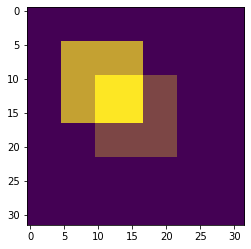

In [10]:
import numpy as np
# generate some test objecys
A = np.zeros((32, 32))
A[10:-10, 10:-10] = 1
B = np.zeros((32, 32))
B[5:-15, 5:-15] = 1

dice = 2*np.sum(A*B)/(np.sum(A)+np.sum(B))

# display the results
plt.plot()
plt.imshow(A)
plt.imshow(B, alpha=0.7)

print(dice)

In [11]:
from sklearn.metrics import confusion_matrix

confusion_matrix(A.argmax(axis=1),B.argmax(axis=1))

#tn, fp, fn, tp = confusion_matrix(A.argmax(axis=1),B.argmax(axis=1), margins=True)


array([[15,  5,  0],
       [ 0,  0,  0],
       [ 5,  7,  0]], dtype=int64)

In [12]:
def conf_mat(true,pred):
    K = len(np.unique(true))
    result = np.zeros((K,K))
    for i in range(len(true)):
        result[true[i]][pred[i]] +=1
        
    return result

conf_mat(A,B)

IndexError: arrays used as indices must be of integer (or boolean) type

<p><font color='#770a0a'>Show that the $F_1$ score, which is the harmonic mean of precision and recall, is equivalent to the Dice similarity coefficient</font><p>